<a href="https://colab.research.google.com/github/mitran27/GenerativeNetworks/blob/main/Nerf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kornia

In [1]:
import numpy as np
from kornia import create_meshgrid
import torch
from torchvision.transforms import ToTensor
from PIL import Image
import os, json, numpy as np

It's basic geometry:
 you have a right angle triangle, with half the FOV (Field of View) as one of the angles (a), and half your image size as the opposite side (A).
 To calculate the focal length F, use tan(a) = A/F, which gives F = A/tan(a).
  A = Image size /2 , a = FOV / 2

In [2]:
# prompt: calculate focal length  with parameters field of view(as radians)  and image size(as single variable) using numpy  . write a funtion  named calFocalLengthAI

import numpy as np

def calFocalLengthAI(fov_radians, image_size):
  """
  Calculates the focal length of a camera given the field of view and image size.

  Args:
    fov_radians: The field of view of the camera in radians.
    image_size: The size of the image in pixels.

  Returns:
    The focal length of the camera in pixels.
  """

  # Calculate half the FOV and image size
  half_fov = fov_radians / 2
  half_image_size = image_size / 2

  # Use the formula F = A/tan(a) to calculate the focal length
  focal_length = half_image_size / np.tan(half_fov)

  return focal_length



In [3]:
def calFocalLength(cam_x,img_size):
   return  0.5*img_size/np.tan(0.5*cam_x) # original focal length

def get_ray_directions(H, W, focal):
    """
    Get ray directions for all pixels in camera coordinate.

    Inputs:
        H, W, focal: image height, width and focal length

    Outputs:
        directions: (H, W, 3), the direction of the rays in camera coordinate
    """
    i, j = create_meshgrid(H, W, normalized_coordinates=False)[0].unbind(-1)
    """
    i -> x coordinates of all pixel in image (increase in x direction)
    j -> y coordinates of all pixel in image (increase in y direction)
    """


    directions = torch.stack([(i-W/2)/focal, -(j-H/2)/focal, -torch.ones_like(i)], -1) # (H, W, 3)

    # ray direction of all pixels (imaeg all the points are 1 unit away from the camera)
    # center point would be tensor([ 0., -0., -1.])

    return directions

In [4]:
F= calFocalLength(0.6194058656692505, 800)
print(F)
ray_directions = get_ray_directions(800,800,F)
print(ray_directions[400,400])
print(ray_directions[0,0],ray_directions[799,799])

1250.0000504168488
tensor([ 0., -0., -1.])
tensor([-0.3200,  0.3200, -1.0000]) tensor([ 0.3192, -0.3192, -1.0000])


In [5]:
import torch
ray_direction = torch.tensor([4,2],dtype=torch.float32) # 4x+2y direction
ray_direction = ray_direction / torch.norm(ray_direction, dim=-1, keepdim=True)
print(ray_direction)
ray_direction = torch.tensor([2,1],dtype=torch.float32) # 2x+y direction
ray_direction = ray_direction / torch.norm(ray_direction, dim=-1, keepdim=True)
print(ray_direction)
ray_direction = torch.tensor([0.5,0.25],dtype=torch.float32) # .5x+.2y direction
ray_direction = ray_direction / torch.norm(ray_direction, dim=-1, keepdim=True)
print(ray_direction)

# both ae same direction so take norm


tensor([0.8944, 0.4472])
tensor([0.8944, 0.4472])
tensor([0.8944, 0.4472])


In [7]:
!unzip /content/drive/MyDrive/NER_Bert/nerf_synthetic.zip

Streaming output truncated to the last 5000 lines.
  inflating: nerf_synthetic/hotdog/val/r_57.png  
  inflating: __MACOSX/nerf_synthetic/hotdog/val/._r_57.png  
  inflating: nerf_synthetic/hotdog/val/r_56.png  
  inflating: __MACOSX/nerf_synthetic/hotdog/val/._r_56.png  
  inflating: nerf_synthetic/hotdog/val/r_42.png  
  inflating: __MACOSX/nerf_synthetic/hotdog/val/._r_42.png  
  inflating: nerf_synthetic/hotdog/val/r_95.png  
  inflating: __MACOSX/nerf_synthetic/hotdog/val/._r_95.png  
  inflating: nerf_synthetic/hotdog/val/r_81.png  
  inflating: __MACOSX/nerf_synthetic/hotdog/val/._r_81.png  
  inflating: nerf_synthetic/hotdog/val/r_97.png  
  inflating: __MACOSX/nerf_synthetic/hotdog/val/._r_97.png  
  inflating: nerf_synthetic/hotdog/val/r_83.png  
  inflating: __MACOSX/nerf_synthetic/hotdog/val/._r_83.png  
  inflating: nerf_synthetic/hotdog/val/r_54.png  
  inflating: __MACOSX/nerf_synthetic/hotdog/val/._r_54.png  
  inflating: nerf_synthetic/hotdog/val/r_40.png  
  inflating

In [6]:
class DataGenerator():
  def __init__(self, path,img_size, datasetType="train"):

    self.root_dir = path
    self.img_size = img_size
    meta = json.load(open(path+f"transforms_{datasetType}.json"))
    F= calFocalLength(meta['camera_angle_x'], img_size)
    self.origin_ray_directions = get_ray_directions(img_size,img_size,F)

    # Keep all poses in Ram and load image dynamically
    self.poses = []
    self.__loadPoses(meta["frames"])
    #self.__loadImages(meta["frames"])

  def __loadPoses(self, frames):


    for frame in frames:
       # [img_path,pose]
       c2w = torch.FloatTensor(frame['transform_matrix'])[:3, :4]
       self.poses.append([os.path.join(self.root_dir, f"{frame['file_path'][2:]}.png"), c2w])

  def __len__(self):return len(self.poses)

  def _get_rays(self, c2w):
    # convert camera coordinate to world coordinate
    # get the ray direction for pixels corresponding camera pose

    # only directions so dont take xyz Coordinate
    # orgin directions are rays only of Camera in identity position(I)
    # ray direction represent ray from corresponding pose
    ray_direction = self.origin_ray_directions @ c2w[:,:3].T # camera ray direction
    ray_direction = ray_direction / torch.norm(ray_direction, dim=-1, keepdim=True) #direction can impact the scale so normalize it

    H,W,_ = ray_direction.shape
    ray_direction = ray_direction.view(-1,3) # in nerf all are passes as individual rays , no convolution so flatten

    rays_origin = c2w[:,3].expand(H*W,3)# have camera origin for all pixels

    return rays_origin, ray_direction


  def _loadImage(self, path):

    img = Image.open(path)
    img = img.resize((self.img_size,self.img_size), Image.LANCZOS)
    img = np.array(img)


    img = img.reshape(-1,4) # (H*W, 4) RGBA
    valid_mask = img[:,-1] # (H*W) valid color area
    img = img[:, :3]*img[:, -1:] + (1-img[:, -1:]) # blend A to RGB

    return img, valid_mask

  def __getitem__(self, idx):

    path, c2w = self.poses[idx]

    image, valid_mask = self._loadImage(path)

    rays = self._get_rays(c2w)

    return {
        "image" : image , # output
        "rays" : rays , # input
        "mask" : valid_mask ,
    }


In [7]:
dataGenerator = DataGenerator("/content/nerf_synthetic/drums/", 64 )


In [8]:
from torch.nn import Module,Linear,ReLU, Sigmoid, Sequential

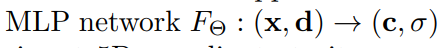

In [21]:
def LinearRelu(in_dim, out_dim):
  return Sequential(
      Linear(in_dim, out_dim),ReLU()
  )
class NERFModel(Module):
  def __init__(self, embedding_dim_x=10, embedding_dim_d=4, hidden_dim=128):

    super().__init__()

    self.emb_x = embedding_dim_x
    self.emb_d = embedding_dim_d

    print("model creation started")

    self.densityBlock = Sequential(
        LinearRelu(3+embedding_dim_x*6, hidden_dim),
        LinearRelu(hidden_dim, hidden_dim),
        LinearRelu(hidden_dim, hidden_dim),
        LinearRelu(hidden_dim, hidden_dim),
        LinearRelu(hidden_dim, hidden_dim),
        LinearRelu(hidden_dim, hidden_dim+1)
    )

    self.colorBlock = Sequential(
        LinearRelu(3+embedding_dim_d*6 + hidden_dim, hidden_dim),
        LinearRelu(hidden_dim, hidden_dim//2),
        LinearRelu(hidden_dim//2, 3),
        Sigmoid()
    )
    self.relu = ReLU()

  @staticmethod
  def positional_encoding(x, L):
      out = [x]
      for j in range(L):
          out.append(torch.sin(2 ** j * x))
          out.append(torch.cos(2 ** j * x))
      return torch.cat(out, dim=1)

  def forward(self, x, d):
    pos_X = self.positional_encoding(x, self.emb_x)
    pos_d = self.positional_encoding(x, self.emb_d)

    H = self.densityBlock(pos_X)
    h,sigma = H[:,:-1] , self.relu(H[:,-1])

    c = self.colorBlock(torch.cat([pos_d,h], dim=-1))

    return sigma, c


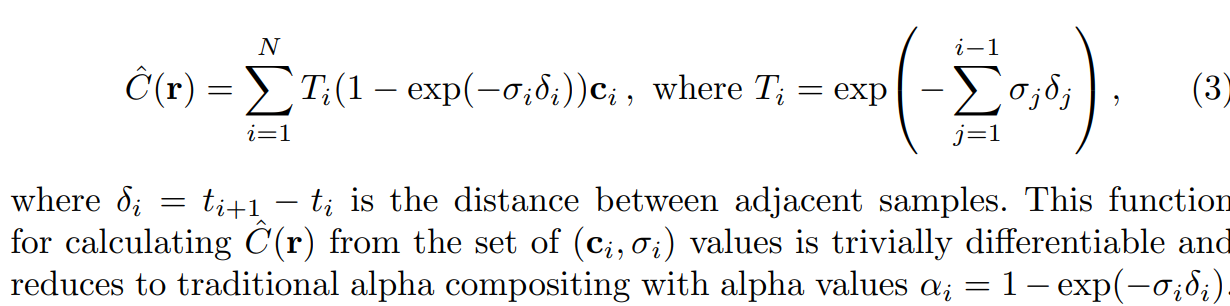

In [43]:
class NERF(Module):
  def __init__(self, near, far, n_bins, random_noise=False):

    # create depth samples at equal intervals for all pixels
    super().__init__()

    self._create_depth_interval(torch.tensor(near), torch.tensor(far), n_bins)
    self.random_noise = random_noise
    self.depth_interval_range = (far-near)/n_bins
    self.nerfModel = NERFModel()

    print("model created")



  def _create_depth_interval(self, near, far, n_bins):
    sampled_bins = torch.linspace(near, far, n_bins)
    # take the center of the sampled bins (optional)
    sampled_bins_mid = (sampled_bins[:-1] + sampled_bins[1:])/2

    depth_intervals = torch.hstack([near, sampled_bins_mid])
    self.N_depths = depth_intervals.shape[0]

    self.depth_intervals = depth_intervals

  def _add_noise(self, depths, device):
    if(self.random_noise):
      depths = depths + torch.rand(depths.shape,device=depths.device) * self.depth_interval_range

    delta = torch.cat([depths[..., 1:] - depths[..., :-1], torch.tensor([1e10]).expand(depths[...,:1].shape)], -1)

    return depths.to(device), delta.to(device)

  def iterate_sample(self, rays_origin, rays_direction): # one image of the 3d object

    # Prepare inputs for Model

    # x -> X, Y, Z of the depth
    # d -> direction

    """
        # x coordinate is origin + depth * direction
        image in a point 3,4 in 2d graph if you want to point a sample of distance 3 in 2x+y direction(normalized)
        ==> (origin+depth*direction)
    """

    no_pixels = rays_direction.shape[0]
    depths = self.depth_intervals.expand(no_pixels,self.N_depths)

    sampled_random_depths, delta = self._add_noise(depths,rays_origin.device)
    X = rays_origin.unsqueeze(1) + sampled_random_depths.unsqueeze(2) * rays_direction.unsqueeze(1) #(no_pixels,no_depths,3)
    #    (no_pixels,1,3)              (no_pixels,no_depths,1)           (no_pixels,1,3)
    d = rays_direction.unsqueeze(1).expand(X.shape)

    sigma, c = self.nerfModel(X.reshape(-1, 3), d.reshape(-1, 3))
    c = c.reshape(X.shape)
    sigma = sigma.reshape(X.shape[:-1])



    exp_sigma_delta = torch.exp(-sigma * delta)

    weight = (torch.cumprod(exp_sigma_delta, 1) * (1-exp_sigma_delta))

    c = (weight.unsqueeze(2) * c).sum(dim=1)

    return c

In [ ]:
nerf = NERF(2,6,32)
optimizer = torch.optim.Adam(nerf.parameters(), lr=1e-4)

from torch.utils.data import DataLoader
from tqdm import tqdm

data_loader = DataLoader(dataGenerator, batch_size=1, shuffle=True)

N_iters = 1000
psnrs = []
iternums = []
i_plot = 25
device = torch.device("cuda")
nerf = nerf.to(device)


import time
t = time.time()
training_loss = []
for i in tqdm(range(100)):
    for batch in data_loader:
        gt_image = batch['image'].to(device)
        rays_origin, ray_direction = batch['rays']
        rays_origin = rays_origin.squeeze(0).to(device)
        ray_direction = ray_direction.squeeze(0).to(device)
        regenerated_px_values = nerf.iterate_sample(rays_origin, ray_direction)
        loss = ((gt_image - regenerated_px_values) ** 2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss.append(loss.item())
    print(sum(training_loss)/len(training_loss))




print('Done')

model creation started
model created


  1%|          | 1/100 [00:08<14:42,  8.92s/it]

10392.427138671876


  2%|▏         | 2/100 [00:17<14:16,  8.74s/it]

10371.732299804688


  3%|▎         | 3/100 [00:25<13:14,  8.20s/it]

10363.958387044271


  4%|▍         | 4/100 [00:33<13:00,  8.14s/it]

10359.981931152344


  5%|▌         | 5/100 [00:40<12:40,  8.01s/it]

10357.564293945312


  6%|▌         | 6/100 [00:48<12:25,  7.93s/it]

10355.941493326824


In [ ]:

4096*32